# AI Assistant with Gemma 2b-it RAG

In [1]:
from huggingface_hub import login

# Login to Hugging Face
login()

In [2]:
# 인스톨

!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U transformers=="4.38.2"
!pip install -q accelerate
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U sentence_transformers
!pip install -q -U scann
# !pip install -q -U wikipedia-api

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow-decision-forests 1.8.1 requires tensorflow~=2.15.0, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.16.1 which is incompatible.


In [3]:
# 환경설정

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import scann
# import wikipediaapi

import torch

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig,
                         )
from sentence_transformers import SentenceTransformer
import bitsandbytes as bnb

# Proceeding by building blocks

In [6]:
# 디바이스 설정

def define_device():

    defined_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Print a message indicating the selected device
    print(f"using {defined_device}")

    return defined_device


In [7]:
# 임베딩 함수 설정

def get_embedding(text, embedding_model):
    """Get embeddings for a given text using the provided embedding model"""
    
    # Encode the text to obtain embeddings using the provided embedding model
    embedding = embedding_model.encode(text, show_progress_bar=False)
    
    # Convert the embeddings to a list of floats and return
    return embedding.tolist()

def map2embeddings(data, embedding_model):
    """Map a list of texts to their embeddings using the provided embedding model"""
    
    # Initialize an empty list to store embeddings
    embeddings = []

    # Iterate over each text in the input data list
    no_texts = len(data)
    print(f"Mapping {no_texts} pieces of information")
    for i in tqdm(range(no_texts)):
        # Get embeddings for the current text using the provided embedding model
        embeddings.append(get_embedding(data[i], embedding_model))
    
    # Return the list of embeddings
    return embeddings

In [8]:
# 텍스트 정리

def clean_text(txt, EOS_TOKEN):
    """Clean text by removing specific tokens and redundant spaces"""
    txt = (txt
           .replace(EOS_TOKEN, "") # Replace the end-of-sentence token with an empty string
           .replace("**", "")      # Replace double asterisks with an empty string
           .replace("<pad>", "")   # Replace "<pad>" with an empty string
           .replace("  ", " ")     # Replace double spaces with single spaces
           .replace("<bos>", "")
          ).strip()                # Strip leading and trailing spaces from the text
    return txt

In [9]:
# train data preprocessing

DATA_PATH = '/kaggle/input/dobaehaza/'
train = pd.read_csv(f'{DATA_PATH}train.csv')

answer = ['답변_1', '답변_2', '답변_3', '답변_4', '답변_5']
question = ['질문_1', '질문_2']
bag = []
for i in range(len(train)):
    row = train.iloc[i,:]
    bag.extend([{'id':row['id'], 'question':row[j], 'answer':row[i]} for j in question for i in answer])

train = pd.DataFrame(bag)
train.sample(5)

,id,question,answer
4122,TRAIN_412,옥상 방수용 탄성 에멀젼 페인트가 뭐야?,옥상 방수용 탄성 에멀젼 페인트는 동절기의 혹한과 하절기의 혹서에도 효과적인 방수성...
1544,TRAIN_154,도배와 페인트 시공 중 뭐가 더 비용이 많이 들어?,일반적으로 도배보다 페인트 시공이 더 많은 비용이 발생합니다. 이는 페인트가 보다 ...
4808,TRAIN_480,도배를 할 때 어떤 순서로 진행하는 것이 좋을까요?,도배 작업을 진행하는 순서는 다음과 같습니다. 1. 짐 이동 2. 박리 작업 3. ...
2698,TRAIN_269,써모사이딩은 어떤 재질로 만들어져 있나요?,"써모사이딩은 일명 메탈사이딩이라고 불리며, 알루미늄 합금 강판에 고내후성 도료를 코..."
2377,TRAIN_237,폴리싱 타일을 사용하는 장점은 무엇인가요?,"폴리싱 타일은 내구성이 뛰어나고 변형 및 오염, 얼룩에 강해서 오랫동안 사용할 수 ..."


In [257]:
# gemma model bitsandbytes config

class GemmaHF():
    """Wrapper for the Transformers implementation of Gemma"""
    
    def __init__(self, model_name, max_seq_length=1024):
        self.model_name = model_name
        self.max_seq_length = max_seq_length
        
        # Initialize the model and tokenizer
        print("\nInitializing model:")
        self.device = define_device()
        self.model, self.tokenizer = self.initialize_model(self.model_name, self.device, self.max_seq_length)
        
    def initialize_model(self, model_name, device, max_seq_length):
        """Initialize a 4-bit quantized causal language model (LLM) and tokenizer with specified settings"""

        # Define the data type for computation
        compute_dtype = getattr(torch, "float16")

        # Define the configuration for quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
        )

        # Load the pre-trained model with quantization configuration
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map=device,
            quantization_config=bnb_config,
        )

        # Load the tokenizer with specified device and max_seq_length
        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            device_map=device,
            max_seq_length=max_seq_length
        )
        
        # Return the initialized model and tokenizer
        return model, tokenizer
    
    def generate_text(self, prompt, max_new_tokens=1024, temperature=0.0):
        """Generate text using the instantiated tokenizer and model with specified settings"""
    
        # Encode the prompt and convert to PyTorch tensor
        input_ids = self.tokenizer(prompt, return_tensors="pt", padding=True).to(self.device)

        # Determine if sampling should be performed based on temperature
        do_sample = True if temperature > 0 else False

        # Generate text based on the input prompt
        outputs = self.model.generate(**input_ids, 
                                      max_new_tokens=max_new_tokens, 
                                      do_sample=do_sample, 
                                      temperature=temperature
                                     )

        # Decode the generated output into text
        results = [self.tokenizer.decode(output) for output in outputs]

        # Return the list of generated text results
        return results

In [344]:
def generate(question,data, searcher, embedding_model, model, max_new_tokens=1024, temperature=0.3, credit = 80, show = True, role="인공지능"):
        # Get the end-of-sentence token from the tokenizer
    try:
        EOS_TOKEN = model.tokenizer.eos_token
    except:
        EOS_TOKEN = "<eos>"
        
    embeded_question = np.array(get_embedding(question, embedding_model)).reshape(1, -1)

    # Find similar contexts in the dataset based on the embedded question
    neighbors, distances = searcher.search_batched(embeded_question) # 넣었던 data에 대한 index와 거리를 반환 ** 즉 여러개의 답변이 높은 순서로 나오게됨
    
    if show:
        print('reliability: ',distances[0][0])
        
    if distances[0][0] < credit: # 신뢰도가 낮을 경우 일반 답변 출력
        question = role + '로써 답해줘 질문:' + question + '\n\n 답변:'
        result = model.generate_text(question, 1024, temperature)
#         print(result)
        result = clean_text(result[0].split(question)[-1], EOS_TOKEN)
    else:
        # Extract context from the dataset based on the indices of similar contexts
#         prompt = f"[{data[neighbors[0][0]]}]의 정보를 모두 합친 답변을 말해줘 \n 답변: "
#         result = model.generate_text(prompt, max_new_tokens, temperature)
#         result = clean_text(result[0].split('답변: ')[-1], EOS_TOKEN)
        result = data['answer'][neighbors[0][0]]

    return result

In [382]:
def generate_summary_and_answer(question, data, searcher, embedding_model, model,
                                max_new_tokens=1024, temperature=0.4, credit=80, show=True, role="user"):
    """Generate an answer for a given question using context from a dataset"""
    
    # Get the end-of-sentence token from the tokenizer
    try:
        EOS_TOKEN = model.tokenizer.eos_token
    except:
        EOS_TOKEN = "<eos>"
    
    # Split the question based on certain keywords
    keywords = ['그리고', '또한', '요와']
    for keyword in keywords:
        if keyword in question and f"{keyword} 이를" not in question:
            question_parts = [part.strip() for part in question.split(keyword)]
            answer = ' 그리고 '.join([f"{i + 1}. " + generate(part, data, searcher, embedding_model, model, credit=credit, show=show) for i, part in enumerate(question_parts)])
            return answer
    
    # If no keyword is found, generate the answer for the whole question
    answer = generate(question, data, searcher, embedding_model, model, credit=credit, show=show)
    return answer


# Wrapping up everything

In [383]:

class AIAssistant():
    """An AI assistant that interacts with users by providing answers based on a provided knowledge base"""
    
    def __init__(self, gemma_model, embeddings_name="jhgan/ko-sroberta-multitask", temperature=0.4, credit = 80, show : bool = True, role="user"):
        """Initialize the AI assistant."""
        # Initialize attributes
        self.embeddings_name = embeddings_name
        self.knowledge_base = pd.DataFrame()
        self.credit = credit
        self.temperature = temperature
        self.show = show
        self.role = role
        
        # Initialize Gemma model (it can be transformer-based or any other)
        self.gemma_model = gemma_model
        
        # Load the embedding model
        self.embedding_model = SentenceTransformer(self.embeddings_name)
        
    def store_knowledge_base(self, knowledge_base):
        """Store the knowledge base"""
        self.knowledge_base=knowledge_base
        
    def learn_knowledge_base(self, knowledge_base):
        """Store and index the knowledge based to be used by the assistant"""
        # Storing the knowledge base
        self.store_knowledge_base(knowledge_base)
        
        # Load and index the knowledge base
        print("Indexing and mapping the knowledge base:")
        embeddings = map2embeddings(self.knowledge_base['question'], self.embedding_model)
        self.embeddings = np.array(embeddings).astype(np.float32)
        
        # Instantiate the searcher for similarity search
        self.index_embeddings()
        
    def index_embeddings(self):
        """Index the embeddings using ScaNN """
        self.searcher = (scann.scann_ops_pybind.builder(db=self.embeddings, num_neighbors=10, distance_measure="dot_product")
                 .tree(num_leaves=min(self.embeddings.shape[0] // 2, 1000), 
                       num_leaves_to_search=100, 
                       training_sample_size=self.embeddings.shape[0])
                 .score_ah(2, anisotropic_quantization_threshold=0.2)
                 .reorder(100)
                 .build()
           )
        
    def query(self, query):
        """Query the knowledge base of the AI assistant."""
        # Generate and print an answer to the query
        answer = generate_summary_and_answer(query, 
                                             self.knowledge_base, 
                                             self.searcher, 
                                             self.embedding_model, 
                                             self.gemma_model,
                                             temperature=self.temperature,
                                             credit=self.credit,
                                             show = self.show,
                                             role=self.role)
  
        return answer
        

        
    def set_credit(self, credit):
        """Set the credit (reliability) of the AI assistant."""
        self.credit = credit

    def set_show(self, show:bool):
        """ if you don't want to see reliability"""
        self.show = show
        
    def set_temperature(self, temperature):
        """Set the temperature (creativity) of the AI assistant."""
        self.temperature = temperature
        
    def set_role(self, role):
        """Define the answering style of the AI assistant."""
        self.role = role
        
    def save_embeddings(self, filename="embeddings.npy"):
        """Save the embeddings to disk"""
        np.save(filename, self.embeddings)
        
    def load_embeddings(self, filename="embeddings.npy"):
        """Load the embeddings from disk and index them"""
        self.embeddings = np.load(filename)
        # Re-instantiate the searcher
        self.index_embeddings()

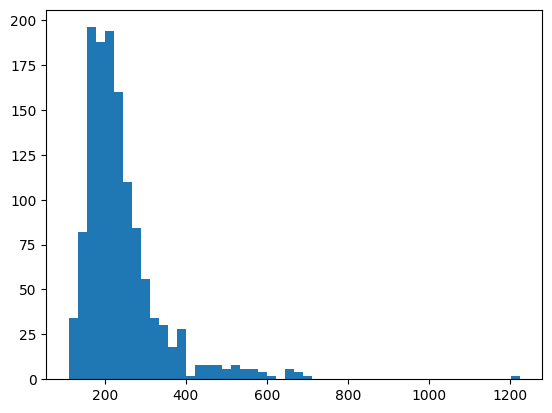

In [387]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in train_g['answer']], bins = 50)
plt.show()

In [384]:
# 가장 긴 질문을 학습
train_g['answer'] = train.groupby('question')['answer'].apply(lambda x: x.loc[x.str.len().idxmax()]).reset_index(drop=True)
train_g

,question,answer
0,2023년의 인기 있는 인테리어 디자인 트렌드는 어떤 것이 있을까요?,"2023년의 최신 인테리어 디자인 트렌드로는 천연 소재 활용, 어스톤 컬러 팔레트, 그리고 지속가능한 디자인이 주목받을 것으로 예상됩니다. 이러한 트렌드는 환경을 고려하면서도 자연스러운 디자인과 색상을 선호하는 현대 사회의 가치관을 반영하고 있습니다. 특히 천연 소재의 인기는 가정 내부뿐만 아니라 식물이나 자연의 원소를 활용한 외부 장식에도 영향을 미칠 것으로 예상됩니다."
1,2023년의 최신 인테리어 디자인 트렌드가 무엇인가요?,"2023년의 최신 인테리어 디자인 트렌드로는 천연 소재 활용, 어스톤 컬러 팔레트, 그리고 지속가능한 디자인이 주목받을 것으로 예상됩니다. 이러한 트렌드는 환경을 고려하면서도 자연스러운 디자인과 색상을 선호하는 현대 사회의 가치관을 반영하고 있습니다. 특히 천연 소재의 인기는 가정 내부뿐만 아니라 식물이나 자연의 원소를 활용한 외부 장식에도 영향을 미칠 것으로 예상됩니다."
2,ABC 소화기가 뭐야?,"ABC 소화기는 일반적으로 가장 많이 볼 수 있는 소화기로 A, B, C 등급의 화재 대응이 가능한 소화기입니다. A는 연소 후 재를 남기는 특성을 고려하여 A급 일반화재를 말하고, B는 유류에 의한 B급 유류 화재, C는 전기에 의한 전기 화재 C급 화재를 뜻합니다. 따라서 ABC 소화기는 다양한 종류의 화재를 대처하는 데 사용될 수 있습니다."
3,ABC 소화기란 무엇인가요?,"ABC 소화기는 일반적으로 가장 많이 볼 수 있는 소화기로 A, B, C 등급의 화재 대응이 가능한 소화기입니다. A는 연소 후 재를 남기는 특성을 고려하여 A급 일반화재를 말하고, B는 유류에 의한 B급 유류 화재, C는 전기에 의한 전기 화재 C급 화재를 뜻합니다. 따라서 ABC 소화기는 다양한 종류의 화재를 대처하는 데 사용될 수 있습니다."
4,"AD, PD에 면한 벽체 결로에 대한 대책은 뭐야?","AD, PD에 면한 벽체 결로에 대한 대책은 단열재를 미실하게 시공하여 결로가 생기는 벽체의 표면 온도를 노점온도 이상으로만 유지해주는 것이 중요합니다. 그 외에도 실외습기의 유입을 차단하고, 적절한 환기 시스템을 활용하여 공간 내 습도를 유지하고 벽체 표면을 건조하게 유지하는 것이 필요합니다. 또한, 외피의 방수 및 수증기 차단 기능을 강화하여 벽체 내부로의 습기 유입을 최소화해야 합니다. 일반적으로는 벽체의 표면뿐만 아니라 내부적으로도 겉지문 및 방수층의 철저한 시공이 필요합니다."
...,...,...
1281,흡음재 중 다공질이 뭐야?,"흡음재 중 다공질은 미세 구멍이나 틈이 많이 있는 소재를 말합니다. 유리면, 암면, 목모판, 코르크 판, 석고보드, 콘크리트 블록 등이 이에 해당하며, 다공질은 고주파 흡음률이 뛰어나다는 특징을 갖고 있습니다. 이는 주로 높은 주파수 소리를 흡수하는 데 효과적이며, 공간 내에서의 반향과 에코를 줄이는 데 도움을 줍니다."
1282,흡음재 중 판 진동형이 뭐야?,"판 진동형 흡음재는 간격을 두고 얇고 통기성이 없는 판을 설치하여 소리가 전달될 때 판이 진동하여 마찰에 의해 소리가 소멸되는 흡음재입니다. 이러한 형태의 흡음재는 저주파의 진동음을 소멸시키는 특징이 있으며, 주로 소리를 흡수하는 것보다는 진동음을 소멸시키는 데 뛰어나다고 합니다. 따라서, 높은 주파수의 소리에는 효과적이지만, 흡음률이 상대적으로 높지 않을 수 있습니다."
1283,흡음재 중에 다공질이 무엇인가요?,"흡음재 중 다공질은 미세 구멍이나 틈이 많이 있는 소재를 말합니다. 유리면, 암면, 목모판, 코르크 판, 석고보드, 콘크리트 블록 등이 이에 해당하며, 다공질은 고주파 흡음률이 뛰어나다는 특징을 갖고 있습니다. 이는 주로 높은 주파수 소리를 흡수하는 데 효과적이며, 공간 내에서의 반향과 에코를 줄이는 데 도움을 줍니다."
1284,흡음재 중에서 공명형은 무엇을 의미하는 건가요?,"흡음재 중 공명형은 작은 구멍이나 틈을 이용하여 소리의 공명을 이용하는 재질을 말합니다. 이러한 소재는 석면 시멘트판, 석고보드, 알루미늄판, 연질 섬유판, 합성수지판 등이 있으며, 구멍 내부로 들어간 소리가 공명에 의해 소멸되는 구조로 설계되어 특정 주파수에 적용됩니다. 이를 통해 원하는 주파수대에서의 소리 흡수가 가능하며, 또한 특정 주파수의 소리를 강화시킬 수 있습니다."


# test run

In [390]:
# Initialize the name of the embeddings and model
embeddings_name = "jhgan/ko-sroberta-multitask"
model_name = "google/gemma-2b-it"

# Create an instance of AIAssistant with specified parameters
gemma_ai_assistant = AIAssistant(gemma_model=GemmaHF(model_name), embeddings_name=embeddings_name)

# Map the intended knowledge base to embeddings and index it
gemma_ai_assistant.learn_knowledge_base(knowledge_base=train_g)

# Save the embeddings to disk (for later use)
gemma_ai_assistant.save_embeddings()

# Set the temperature (creativity) of the AI assistant and set the role
# gemma_ai_assistant.set_temperature(0.0)
# gemma_ai_assistant.set_role("AI expert")
# Set the credit (reliability) of the AI assistant
# gemma_ai_assistant.set_credit(90) # default = 80
# gemma_ai_assistant.set_show(False) # default = True


Initializing model:
using cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Indexing and mapping the knowledge base:
Mapping 1286 pieces of information


100%|██████████| 1286/1286 [00:18<00:00, 69.01it/s]


Let's start with a warm-up question: "What is the difference between data science, machine learning, and artificial intelligence?"


In [357]:
gemma_ai_assistant.set_show(True)
gemma_ai_assistant.set_credit(80)

In [361]:
train.sample(5)

,id,question,answer
1889,TRAIN_188,흡연으로 인해 벽지가 변색되는 것을 방지하려면 어떤 조치를 취해야 할까요?,"실내흡연을 하게 되면 담배 연기에 함유된 니코틴, 수은 및 기타 화학물질이 벽지에 흡착되어 노폐물이 쌓여 벽지가 변색될 수 있습니다. 특히 밝은 색상의 벽지나 흡수성이 높은 종이 벽지는 특히 민감하며 변색될 가능성이 높습니다. 때문에 실내 흡연 시 벽지 위에 붙은 노폐물을 제거하는 것이 중요합니다."
2186,TRAIN_218,페인트에 포함된 유해물질은 어떤 것들이 있나요?,"페인트에 함유된 주요 유해물질로는 벤젠, 톨루엔, 자일렌 등이 있습니다. 이러한 유해물질은 흡입이나 피부 흡수를 통해 건강에 해를 끼칠 수 있으며, 특히 VOCs(휘발성 유기 화합물)와 같은 발암 물질의 함량이 높을 경우 새집증후군과 같은 문제를 유발할 수 있습니다. 따라서 페인트 작업 시에는 적절한 환기 시스템을 동반하는 것이 중요하며, 개인보호구인 마스크를 착용하는 것이 필요합니다. 환경부는 실내에 유성페인트 사용을 금지하고 수성페인트 사용을 권장하여 휘발성 유기 화합물의 위험에 대비하고 있습니다."
4008,TRAIN_400,배관공사를 할 때 어떤 점에 주의해야 할까요?,"배관공사를 할 때에는 몇 가지 주의해야 할 점이 있습니다. 먼저, 배관은 높이 혹은 기울기를 조절하여 물이 원활하게 흐를 수 있도록 설치하여야 합니다. 또한, 통기구를 적절히 설치하여 배수관에서 공기가 빠르게 흐를 수 있도록 하는 것이 중요합니다. 마지막으로, 소제구를 설치하여 배관 시스템의 압력을 안정화시키고, 배수를 원활히 할 수 있도록 해야 합니다. 이러한 점들을 주의하여 배관공사를 진행해야 합니다."
408,TRAIN_040,새집증후군에 대해 좀 더 알려주세요.,"새집증후군이란 신축이나 리모델링, 인테리어 작업 이후에 발생하는 실내 공기 오염으로 인한 건강 문제를 말합니다. 주로 휘발성 유기 화합물에 의해 눈, 코, 목의 통증이나 두통, 호흡기 문제, 아토피 피부염 등의 증상이 나타나는데, 이는 화학 물질에 민감한 사람들에게 영향을 미칩니다. 실내 환경을 개선하고 화학 물질을 줄이는 등의 조치로 증상을 완화할 수 있습니다."
5794,TRAIN_579,어떻게 중키친을 효과적으로 디자인할 수 있을까요?,"중키친을 효과적으로 디자인하기 위해서는 우선적으로 작업대의 크기와 배치, 수납 공간, 유연한 사용성을 고려해야 합니다. 또한, 주방의 형태와 크기, 사용자의 요구에 맞게 설계해야 합니다. 중키친은 대형 작업대와 스토리지 공간을 충분히 고려하여 설계해야 합니다. 이를 통해 조리환경을 효율적으로 활용할 수 있으며, 조리 및 청소 시간을 단축할 수 있습니다. 따라서 효율적인 중키친 디자인을 위해서는 이러한 사항들을 고려하여 설계하는 것이 중요합니다."


### 말이 조금 달라지더라도 인식할 수 있는지 test

In [362]:
gemma_ai_assistant.query("흡연으로 인해 벽지가 변색되는 것을 방지하려면 어떤 조치를 취해야 할까요?")

reliability:  118.52248
실내흡연을 하면 벽지가 노랗게 변색될 수 있습니다. 특히, 담배 연기에 함유된 니코틴과 기름질 물질이 벽지에 스며들면 변색 현상이 나타날 수 있습니다. 따라서 실내흡연자는 벽지를 깨끗하게 유지하기 위해 정기적으로 벽지 청소를 하는 것이 좋습니다. 또한 벽지를 교체하거나 특수한 벽지 코팅 솔루션을 사용하여 피해를 최소화할 수도 있습니다.


In [364]:
gemma_ai_assistant.query("담배를 펴서 변색이되는 것을 방지하려면?")

reliability:  97.912186
실내흡연을 하면 벽지가 노랗게 변색될 수 있습니다. 특히, 담배 연기에 함유된 니코틴과 기름질 물질이 벽지에 스며들면 변색 현상이 나타날 수 있습니다. 따라서 실내흡연자는 벽지를 깨끗하게 유지하기 위해 정기적으로 벽지 청소를 하는 것이 좋습니다. 또한 벽지를 교체하거나 특수한 벽지 코팅 솔루션을 사용하여 피해를 최소화할 수도 있습니다.


In [365]:
gemma_ai_assistant.query("담배를 펴서 변색이되는 것을 막으려면?")

reliability:  95.290665
실내흡연을 하면 벽지가 노랗게 변색될 수 있습니다. 특히, 담배 연기에 함유된 니코틴과 기름질 물질이 벽지에 스며들면 변색 현상이 나타날 수 있습니다. 따라서 실내흡연자는 벽지를 깨끗하게 유지하기 위해 정기적으로 벽지 청소를 하는 것이 좋습니다. 또한 벽지를 교체하거나 특수한 벽지 코팅 솔루션을 사용하여 피해를 최소화할 수도 있습니다.


In [363]:
gemma_ai_assistant.query("페인트에 포함된 유해물질은 어떤 것들이 있나요?")

reliability:  137.45427
페인트에는 건강에 해로운 다양한 화합물이 함유되어 있습니다. 페인트의 유해물질로는 벤젠, 톨루엔, 자일렌과 같은 VOCs(휘발성 유기 화합물) 등이 있습니다. 이러한 유해물질은 호흡기나 피부를 통해 체내로 흡수될 경우 건강에 악영향을 끼칠 수 있으며, 특히 VOCs는 발암 물질로 분류되어 있습니다. 실제로 새 집 증후군과 같은 문제의 일부 원인으로 알려져 있습니다. 따라서 페인트 작업 시에는 적절한 환기 시설을 마련하여 공기 중의 유해물질 농도를 낮추는 것이 중요합니다. 또한 개인 보호구로서 마스크 착용과 같은 조치도 필요합니다. 이에 환경부는 휘발성 유기 화합물의 위험에 대비해 실내에서는 유성페인트 사용을 금지하고, 수성페인트를 사용하는 것을 권장하고 있습니다.


In [366]:
gemma_ai_assistant.query("페인트에 유해물질은 어떤 것들이 있나요?")

reliability:  136.90958
페인트에는 건강에 해로운 다양한 화합물이 함유되어 있습니다. 페인트의 유해물질로는 벤젠, 톨루엔, 자일렌과 같은 VOCs(휘발성 유기 화합물) 등이 있습니다. 이러한 유해물질은 호흡기나 피부를 통해 체내로 흡수될 경우 건강에 악영향을 끼칠 수 있으며, 특히 VOCs는 발암 물질로 분류되어 있습니다. 실제로 새 집 증후군과 같은 문제의 일부 원인으로 알려져 있습니다. 따라서 페인트 작업 시에는 적절한 환기 시설을 마련하여 공기 중의 유해물질 농도를 낮추는 것이 중요합니다. 또한 개인 보호구로서 마스크 착용과 같은 조치도 필요합니다. 이에 환경부는 휘발성 유기 화합물의 위험에 대비해 실내에서는 유성페인트 사용을 금지하고, 수성페인트를 사용하는 것을 권장하고 있습니다.


In [367]:
gemma_ai_assistant.query("페인트에 유해물질이 있나요?")

reliability:  128.55371
페인트에는 건강에 해로운 다양한 화합물이 함유되어 있습니다. 페인트의 유해물질로는 벤젠, 톨루엔, 자일렌과 같은 VOCs(휘발성 유기 화합물) 등이 있습니다. 이러한 유해물질은 호흡기나 피부를 통해 체내로 흡수될 경우 건강에 악영향을 끼칠 수 있으며, 특히 VOCs는 발암 물질로 분류되어 있습니다. 실제로 새 집 증후군과 같은 문제의 일부 원인으로 알려져 있습니다. 따라서 페인트 작업 시에는 적절한 환기 시설을 마련하여 공기 중의 유해물질 농도를 낮추는 것이 중요합니다. 또한 개인 보호구로서 마스크 착용과 같은 조치도 필요합니다. 이에 환경부는 휘발성 유기 화합물의 위험에 대비해 실내에서는 유성페인트 사용을 금지하고, 수성페인트를 사용하는 것을 권장하고 있습니다.


### 도배와 관련없는 답변

In [368]:
gemma_ai_assistant.query("오늘 날씨를 알려줘")

reliability:  66.04598
오늘 날씨는 15도C입니다.


In [369]:
gemma_ai_assistant.query("맛있는 피자를 만는 법")

reliability:  41.594517
1. 피자의 재료를 정확하게 선택하기
2. 피자의 크기와 형상을 정확하게 조절하기
3. 피자의 밥과 재료의 비율을 정확하게 조절하기
4. 피자를 정확한 방법으로 굽기
5. 피자를 정확한 기름으로 튀기
6. 피자를 완벽한 상태로 섭취하기

맛있는 피자를 만드는 데는 여러 가지 중요한 요소가 있다. 피자의 재료, 크기, 밥과 재료의 비율, 굽기 방법과 기름의 사용 등이 모두 중요한 역할을 한다.


## Test run

In [404]:
# test run

import random
rand_num = random.choices(range(len(train)), k=100)
gemma_ai_assistant.set_show(False)

# Embedding Vector 추출에 활용할 모델(distiluse-base-multilingual-cased-v1) 불러오기
test_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# 샘플에 대한 Cosine Similarity 산식
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b) if norm_a != 0 and norm_b != 0 else 0

sample_scores = []
for i in rand_num:
    question, gt = train.iloc[i]['question'], train.iloc[i]['answer']
    pred = gemma_ai_assistant.query(question)

    # 생성된 답변 내용을 512 Embedding Vector로 변환
    pred_embed = test_model.encode(pred)
    gt_embed = test_model.encode(gt)

    sample_score = cosine_similarity(gt_embed, pred_embed)
    # Cosine Similarity Score가 0보다 작으면 0으로 간주
    sample_score = max(sample_score, 0)
#     print('예측 : ', pred)
#     print('정답 : ', gt)
    print('Cosine Similarity Score : ', sample_score)
#     print('-'*20)
    sample_scores.append(sample_score)
print('전체 샘플의 Cosine Similarity Score 평균 : ', np.mean(sample_scores))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.6334345


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8434361


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.93278265


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8801956


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9464332


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.94471633


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7023423


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.88300186


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.94481486


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.99999994


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.88085014


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.53817666


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9013178


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7962248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.5991253


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.99999994


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.91689163


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.99999994


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9578805


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.88845664


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.73219657


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8910247


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8289754


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.90086913


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.88050425


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9051361


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7601094


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.65731686


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.77644837


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.42824417


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.48080453


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7528559


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.4020697


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.67485857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8194105


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8312495


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9202702


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9235334


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.91457313


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.770931


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9393217


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8960966


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.918073


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7159458


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7940907


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7334173


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9468914


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.76301724


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.84571576


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9528999


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8706068


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0000001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.84859383


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0000001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.5257248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.83382


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9417598


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9221943


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.821926


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8477023


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0000001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7737413


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.83173686


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.72122073


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8742748


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.932431


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9216917


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.76282233


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8244629


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0000001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9735708


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.5822795


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.47373867


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.89596385


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.8898771


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.49510834


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.99999994


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.89522064


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.6178672


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.83606446


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  1.0000001


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.75673676


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.6244514


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.49843186


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.9222986


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity Score :  0.7420075
전체 샘플의 Cosine Similarity Score 평균 :  0.84405255


In [153]:
test = pd.read_csv(f'{DATA_PATH}/test.csv')
test.sample(5)

,id,질문
109,TEST_109,도배지를 너무 작게 자르면 어떤 문제가 발생할 수 있을까요? 그리고 높은 습도로 인해 도배지 패턴이 이어지지 않을 수 있는 이유가 무엇일까요?
74,TEST_074,"상도작업은 어떻게 이뤄지나요? 또한, 공간을 넓게 보이도록 인테리어를 꾸미는 방법은 뭐가 있을까요?"
101,TEST_101,"결로의 발생 원인은 무엇이고, 이를 방지하기 위해 어떤 시공방법을 사용해야 하나요?"
99,TEST_099,철근콘크리트 구조에 대해 좀 더 자세히 알려주세요. 그리고 통나무구조 방식은 어떤 건물에 사용되는 건축 구조 방식인가요?
85,TEST_085,페인트 처리 시 페인트의 양에 따라 어떤 절차를 따라야 하나요?


In [405]:
gemma_ai_assistant.set_show(True)
for i in test['질문']:
    gemma_ai_assistant.query(i)

reliability:  128.15436
reliability:  123.504005
reliability:  91.352196
reliability:  110.148224
reliability:  109.990486
reliability:  94.54266
reliability:  97.12793
reliability:  109.97297
reliability:  108.75932
reliability:  115.78947
reliability:  96.16665
reliability:  95.15817
reliability:  98.63281
reliability:  94.74184
reliability:  120.22739
reliability:  128.7067
reliability:  116.9452
reliability:  94.52328
reliability:  107.39241
reliability:  113.07401
reliability:  132.6805
reliability:  123.86312
reliability:  113.100655
reliability:  117.00419
reliability:  109.36757
reliability:  97.17538
reliability:  96.88369
reliability:  118.059784
reliability:  127.34274
reliability:  96.57601
reliability:  103.28185
reliability:  112.73053
reliability:  113.59442
reliability:  113.100655
reliability:  113.918785
reliability:  126.58182
reliability:  115.20384
reliability:  117.575745
reliability:  97.23359
reliability:  103.06821
reliability:  114.30393
reliability:  130.2186

# Preparing for deploying the model

In [406]:
# Initialize the name of the embeddings and model
embeddings_name = "jhgan/ko-sroberta-multitask"
model_name = "google/gemma-2b-it"

# Create an instance of AIAssistant with specified parameters
gemma_ai_assistant = AIAssistant(gemma_model=GemmaHF(model_name), embeddings_name=embeddings_name)

# Uploading the knowledge base and embeddings to the AI assistant
gemma_ai_assistant.store_knowledge_base(knowledge_base=train_g)
gemma_ai_assistant.load_embeddings(filename="embeddings.npy")


Initializing model:
using cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [407]:
gemma_ai_assistant.query("몰딩수정은 뭐야?")

reliability:  137.53589


'몰딩 수정은 벽면과 몰딩 사이에 이격이 있거나, 몰딩이 파손된 상태를 가리키며, 디자인적 결함으로도 흔히 볼 수 있습니다. 몰딩 수정이 발생하는 원인, 책임소재, 그리고 해결 방법을 설명드리겠습니다.  1. 환경적 요인 원인: 몰딩이 햇빛, 습기, 화학물질 또는 다른 외부 요인에 노출될 때 수정이 발생할 수 있습니다. 책임소재: 건물의 소유자나 거주자가 책임이 있습니다. 해결 방법: 주로 몰딩을 교체합니다. 수정을 방지하기 위해 내구성이 강한 몰딩 소재를 선택하는 것이 필요합니다.  2. 내구성 원인: 몰딩 재료 자체의 내구성이 낮아서 수정이 발생할 수 있습니다. 책임소재: 재료를 선택한 시공자 혹은 시공업체가 책임이 있습니다. 해결 방법: 내구성이 강한 몰딩 소재를 사용하거나 정기적인 유지보수를 통해 이를 방지할 필요가 있습니다.  3. 미세한 오염 원인: 몰딩 표면에 먼지, 오염물이 쌓이면서 시각적으로 수정이 발생할 수 있습니다. 책임소재: 건물의 관리자나 소유자, 혹은 시설 유지업체가 책임이 있습니다. 해결 방법: 정기적인 청소 및 유지 보수를 통해 몰딩을 깨끗하게 유지하고 수정 현상을 방지해야 합니다.'